In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras import models
from keras import optimizers
from keras.applications.resnet import ResNet101, preprocess_input
import datetime
from keras.optimizers import Adam

from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten


import cv2



# Preprocessing

In [2]:
#rmdir ../../data/train/.ipynb_checkpoints

In [3]:
train_dir = '../../data/train'
validation_dir = '../../data/dev'
test_dir = '../../data/test'

In [4]:

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=50,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_dir, 
                                                        target_size=(224, 224), 
                                                        batch_size=50, 
                                                        class_mode='categorical')

Found 12422 images belonging to 7 classes.
Found 1458 images belonging to 7 classes.


In [4]:
train_generator.class_indices

{'earthquake': 0,
 'fire': 1,
 'flood': 2,
 'hurricane': 3,
 'landslide': 4,
 'not_disaster': 5,
 'other_disaster': 6}

# Basline CNN Model

In [5]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape= (224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
#model.add(layers.Dropout(0.3))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(7, activation = 'softmax'))

opt = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=2,
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=10)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/10
2/2 [==============================] - 72s 36s/step - loss: 6.3383 - acc: 0.3000 - val_loss: 16.4495 - val_acc: 0.2000
Epoch 2/10
2/2 [==============================] - 69s 35s/step - loss: 9.6159 - acc: 0.2000 - val_loss: 2.4851 - val_acc: 0.0820
Epoch 3/10
2/2 [==============================] - 67s 34s/step - loss: 2.2309 - acc: 0.0900 - val_loss: 1.9119 - val_acc: 0.3100
Epoch 4/10
2/2 [==============================] - 74s 37s/step - loss: 1.7663 - acc: 0.3800 - val_loss: 2.0182 - val_acc: 0.2920
Epoch 5/10
2/2 [==============================] - 72s 36s/step - loss: 1.8391 - acc: 0.2800 - val_loss: 1.8558 - val_acc: 0.2060
Epoch 6/10
2/2 [==============================] - 68s 34s/step - loss: 1.8540 - acc: 0.2300 - val_loss: 1.8030 - val_acc: 0.2686
Epoch 7/10
2/2 [==============================] - 71s 35s/step - loss: 1.8672 - acc: 0.2500 - val_loss: 1.8315 - val_acc: 0.3000
Epoch 8/10
2/2 [==============================] - 72s 36s/step - loss: 1.8192 - acc: 0.3000 - va

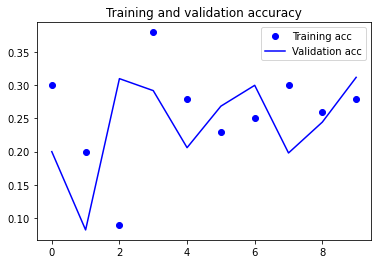

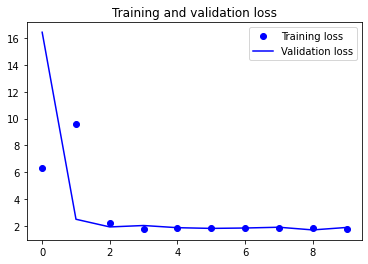

In [6]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#model.save('Baseline_CNN_dog_subset_run2.h5')

# Test Validation

In [5]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=20,
                                                  class_mode='categorical',
                                                  shuffle=False)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=54)
y_hat_test = model.prdedict_generator(test_generator, steps=54)
print('Generated {} predictions'.format(len(y_hat_test)))
print('test acc:', test_acc)

Found 3147 images belonging to 7 classes.
Generated 1080 predictions
test acc: 0.4027777910232544


# ResNet101 Model

In [18]:
batch_size = 8

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   zoom_range=0.4,
                                   horizontal_flip=True
                                   )



train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))





validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)



validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(150, 150)
                                                             )



callbacks = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')        
# autosave best Model
best_model_file = '.../resnet101_drop_batch_best_weights_256.h5'
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)


#wp = '.../resnet101_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet101_base = ResNet101(include_top=False, weights=None,
                           input_tensor=None, input_shape=(150, 150,3))



print('Adding new layers...')
output = resnet101_base.get_layer(index = -1).output  
output = layers.Flatten()(output)
# let's add a fully-connected layer
output = layers.Dense(512,activation = "relu")(output)
output = layers.BatchNormalization()(output)
output = layers.Dropout(0.2)(output)
output = layers.Dense(512,activation = "relu")(output)
output = layers.BatchNormalization()(output)
output = layers.Dropout(0.2)(output)
output = layers.Dense(7, activation='softmax')(output)
print('New layers added!')



resnet101_model = Model(resnet101_base.input, output)
for layer in resnet101_model.layers[:-7]:
    layer.trainable = False

resnet101_model.summary()



resnet101_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics =['accuracy'])



history = resnet101_model.fit_generator(train_generator,
                              epochs=30,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks = [callbacks, best_model]
                              )



#target_dir = '.../weather_pred/'
#if not os.path.exists(target_dir):
#  os.mkdir(target_dir)
#resnet101_model.save(target_dir + 'resnet101_model.h5')
#resnet101_model.save_weights(target_dir + 'resnet101_weights.h5')



acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))



fig = plt.figure(figsize=(20,10))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy of ResNet101')
#plt.ylim([0.7, 1])
plt.legend(loc='lower right')
#plt.show()
#fig.savefig('.../Accuracy_curve_resnet101_drop_batch_256.jpg')



fig2 = plt.figure(figsize=(20,10))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss of ResNet101')
#fig2.savefig('.../Loss_curve_resnet101_drop_batch_256.jpg')



Found 12422 images belonging to 7 classes.
Found 1458 images belonging to 7 classes.
Adding new layers...
New layers added!
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         co

Epoch 1/30
  35/1553 [..............................] - ETA: 1:23:15 - loss: 2.5709 - accuracy: 0.2143

KeyboardInterrupt: 

# VGG16 from scratch

In [3]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(train_dir,target_size=(224,224))

tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(validation_dir, target_size=(224,224))

Found 12422 images belonging to 7 classes.
Found 1458 images belonging to 7 classes.


In [8]:
model = models.Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=7, activation="softmax"))

In [10]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 256)      

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

hist = model.fit_generator(steps_per_epoch=100,generator=traindata, validation_data= testdata, validation_steps=10,epochs=100,callbacks=[checkpoint,early])

# VGG16 Transfer learning

In [13]:
from keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights='imagenet', include_top=True)

553467904/553467096 [==============================] - 48s 0us/step


In [14]:
for layers in (vggmodel.layers)[:19]:
    print(layers)
    layers.trainable = False

In [15]:
X= vggmodel.layers[-2].output
predictions = Dense(7, activation="softmax")(X)
model_final = Model(input = vggmodel.input, output = predictions)

/Users/ryanreilly/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=40, verbose=1, mode='auto')
model_final.fit_generator(generator= traindata, steps_per_epoch= 2, epochs= 100, validation_data= testdata, validation_steps=1, callbacks=[checkpoint,early])
model_final.save_weights("vgg16_1.h5")

Epoch 1/100
2/2 [==============================] - 92s 46s/step - loss: 2.9326 - accuracy: 0.2031 - val_loss: 2.7947 - val_accuracy: 0.2188
Epoch 2/100


/Users/ryanreilly/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/Users/ryanreilly/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2/2 [==============================] - 90s 45s/step - loss: 3.2806 - accuracy: 0.1406 - val_loss: 2.9860 - val_accuracy: 0.0625
Epoch 3/100
2/2 [==============================] - 91s 45s/step - loss: 2.7709 - accuracy: 0.2031 - val_loss: 2.4126 - val_accuracy: 0.3125
Epoch 4/100
2/2 [==============================] - 91s 46s/step - loss: 2.4229 - accuracy: 0.2031 - val_loss: 2.7428 - val_accuracy: 0.2500
Epoch 5/100
2/2 [==============================] - 68s 34s/step - loss: 1.8225 - accuracy: 0.5000 - val_loss: 2.3796 - val_accuracy: 0.2188
Epoch 6/100
2/2 [==============================] - 90s 45s/step - loss: 2.1218 - accuracy: 0.3750 - val_loss: 2.1506 - val_accuracy: 0.3438
Epoch 7/100
2/2 [==============================] - 91s 46s/step - loss: 1.8714 - accuracy: 0.4062 - val_loss: 1.8193 - val_accuracy: 0.4688
Epoch 8/100
2/2 [==============================] - 93s 47s/step - loss: 1.9294 - accuracy: 0.3906 - val_loss: 2.2472 - val_accuracy: 0.2500
Epoch 9/100
2/2 [===============

KeyboardInterrupt: 

# Inception

In [18]:
from keras.applications import InceptionV3

In [19]:
original_model    = InceptionV3()
bottleneck_input  = original_model.get_layer(index=0).input
bottleneck_output = original_model.get_layer(index=-2).output
bottleneck_model  = Model(inputs=bottleneck_input, outputs=bottleneck_output)

96116736/96112376 [==============================] - 13s 0us/step


AttributeError: 'str' object has no attribute 'decode'

In [ ]:
for layer in bottleneck_model.layers:
    layer.trainable = False

In [ ]:
new_model = Sequential()
new_model.add(bottleneck_model)
new_model.add(Dense(7, activation=‘softmax’, input_dim=2048))

In [ ]:
opt = Adam(lr=0.001)

new_model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

one_hot_labels = keras.utils.to_categorical(labels, num_classes=7)

new_model.fit_generator(generator= traindata, steps_per_epoch= 2, epochs= 10, validation_data= testdata, validation_steps=1, callbacks=[checkpoint,early])

# VGG16 Transfer learning - using tutorial